<a href="https://colab.research.google.com/github/danya-pixel/cv-skoltech-course/blob/main/CV_Intro_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetune YOLOv8 from Grounding DINO

<div align="center">

  <a href="https://ultralytics.com/yolov8" target="_blank">
    <img width="1024", src="https://raw.githubusercontent.com/ultralytics/assets/main/yolov8/banner-yolov8.png"></a>


<br>
  <a href="https://console.paperspace.com/github/ultralytics/ultralytics"><img src="https://assets.paperspace.io/img/gradient-badge.svg" alt="Run on Gradient"/></a>
  <a href="https://colab.research.google.com/github/ultralytics/ultralytics/blob/main/examples/tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
  <a href="https://www.kaggle.com/ultralytics/yolov8"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"></a>
<br>

Welcome to the Ultralytics YOLOv8 🚀 notebook! <a href="https://github.com/ultralytics/ultralytics">YOLOv8</a> is the latest version of the YOLO (You Only Look Once) AI models developed by <a href="https://ultralytics.com">Ultralytics</a>. This notebook serves as the starting point for exploring the various resources available to help you get started with YOLOv8 and understand its features and capabilities.

YOLOv8 models are fast, accurate, and easy to use, making them ideal for various object detection and image segmentation tasks. They can be trained on large datasets and run on diverse hardware platforms, from CPUs to GPUs.

We hope that the resources in this notebook will help you get the most out of YOLOv8. Please browse the YOLOv8 <a href="https://docs.ultralytics.com/">Docs</a> for details, raise an issue on <a href="https://github.com/ultralytics/ultralytics">GitHub</a> for support, and join our <a href="https://ultralytics.com/discord">Discord</a> community for questions and discussions!

</div>

## 1. Setup

Based on [medium](https://medium.com/@yongsun.yoon/fine-tuning-yolov8-using-custom-dataset-generated-by-open-world-object-detector-5724e267645d).



In traditional object detection, models are trained to detect objects from a predefined set of categories. Open-world (also called as open-vocabulary or open-set) object detection aims to solve this problem by allowing models to detect arbitrary classes.

Many open-world object detectors leverage vision-language multi-modal training, allowing them to detect the objects of classes that written in human text by fusing the representations of image and language.

______________


Unfortunately, the large size of open-world object detectors makes it difficult to use it in low-resource environments. If we want to detect fixed set of classes (but not included in the benchmark datasets), we can use them as dataset labelers. By fine-tuning small object detection models, such as YOLO, with the generated dataset, we can obtain custom and efficient object detector.


In [ ]:
# setup GroundingDINO
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd GroundingDINO
!pip install -q -e .
%cd ..
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 401 (delta 58), reused 50 (delta 50), pack-reused 316
Receiving objects: 100% (401/401), 12.85 MiB | 31.48 MiB/s, done.
Resolving deltas: 100% (204/204), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.4 MB/s eta 0:00:00
/content


In [ ]:
!pip install -q ultralytics datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.0/617.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00


In [ ]:
import sys
sys.path.append('GroundingDINO')

In [ ]:
import os
import yaml
import numpy as np
import supervision as sv
from PIL import Image
from tqdm.auto import tqdm
from ultralytics import YOLO
from datasets import load_dataset
from groundingdino.util.inference import load_model, load_image, predict, annotate

## 2. Grounding DINO

### Custom Dataset Generation by Open-world Object Detector

To train new class to pretrained object detector, we can chose “food” class and Grounding DINO for open-world object detection. GroundingDINO extends a closed-set detector DINO by performing vision-language modality fusion at multiple phases.

The framework of Grounding DINO is presented below.

<div align="center">

  <a href="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*1byo0nLGRhAZln508M3abw.png" target="_blank">
    <img width="1024", src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*1byo0nLGRhAZln508M3abw.png"></a>

In [ ]:
def run_dino(dino, image, text_prompt='food', box_threshold=0.4, text_threshold=0.1):
    boxes, logits, phrases = predict(
        model = dino,
        image = image,
        caption = text_prompt,
        box_threshold = box_threshold,
        text_threshold = text_threshold
    )
    return boxes, logits, phrases

In [ ]:
dino = load_model('GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py', 'groundingdino_swint_ogc.pth')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


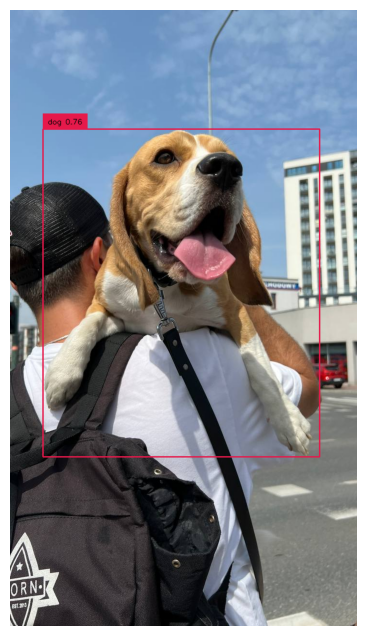

In [ ]:
os.system('wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg')

image_source, image = load_image('dog.jpeg')
boxes, logits, phrases = run_dino(dino, image, text_prompt='dog')

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
sv.plot_image(annotated_frame, (8, 8))

## 3. Annotate Dataset

In [ ]:
def annotate(dino, data, data_size, data_dir):
    data = data.train_test_split(train_size=min(len(data), data_size))['train']

    image_dir = f'{data_dir}/images'
    label_dir = f'{data_dir}/labels'
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for i, d in enumerate(tqdm(data)):
        image_path = f'{image_dir}/{i:06d}.png'
        label_path = f'{label_dir}/{i:06d}.txt'
        image = d['image'].resize((640, 640))
        image.save(image_path)

        image_source, image = load_image(image_path)
        boxes, logits, phrases = run_dino(dino, image)

        label = ['0 ' + ' '.join(list(map(str, b))) for b in boxes.tolist()]
        label = '\n'.join(label)
        with open(label_path, 'w') as f:
            f.write(label)

In [ ]:
data = load_dataset('food101')

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

In [ ]:
annotate(dino, data['train'], 500, 'data/train')
annotate(dino, data['validation'], 20, 'data/valid')

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
config = {
    'names': ['food'],
    'nc': 1,
    'train': 'train/images',
    'val': 'valid/images'
}

with open('data/data.yaml', 'w') as f:
    yaml.dump(config, f)

## 4. Fine-tune YOLOv8

In [ ]:
yolo = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 76.1MB/s]


In [ ]:
yolo.predict('https://ultralytics.com/images/zidane.jpg')


100%|██████████| 165k/165k [00:00<00:00, 8.16MB/s]
image 1/1 /content/zidane.jpg: 384x640 2 persons, 1 tie, 82.9ms
Speed: 21.1ms preprocess, 82.9ms inference, 16.3ms postprocess per image at shape (1, 3, 384, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [ ]:
yolo.train(data='/content/data/data.yaml', epochs=5)

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x782042411540>
fitness: 0.488046626182738
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.45707])
names: {0: 'food'}
plot: True
results_dict: {'metrics/precision(B)': 0.6734057586998764, 'metrics/recall(B)': 0.7318512060447545, 'metrics/mAP50(B)': 0.7667919706770805, 'metrics/mAP50-95(B)': 0.4570749212389221, 'fitness': 0.488046626182738}
save_dir: PosixPath('runs/detect/train')
speed: {'preprocess': 0.2202749252319336, 'inference': 2.936410903930664, 'loss': 0.0008463859558105469, 'postprocess': 1.1570215225219727}

In [ ]:
valid_results = yolo.val()
print(valid_results)

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients
val: Scanning /content/data/valid/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]
                   all         20         31      0.676      0.742      0.768      0.456
Speed: 12.1ms preprocess, 20.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7821d9ec7ca0>
fitness: 0.4874442528796895
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.45631])
names: {0: 'food'}
plot: True
results_dict: {'metrics/precision(B)': 0.6761776040836415, 'metrics/recall(B)': 0.7419354838709677, 'metrics/mAP50(B)': 0.767697509282339, 'metrics/mAP50-95(B)': 0.456305002168284, 'fitness': 0.4874442528796895}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 12.124526500701904, 'inference': 20.844757556915283, 'loss': 0.0021457672119140625, 'postprocess': 1.976156234741211}


## 5. Test fine-tuned YOLOv8

In [ ]:
def run_yolo(yolo, image_url, conf=0.25, iou=0.7):
    results = yolo(image_url, conf=conf, iou=iou)
    res = results[0].plot()[:, :, [2,1,0]]
    return Image.fromarray(res)

In [ ]:
yolo = YOLO('runs/detect/train/weights/best.pt')


100%|██████████| 1.07M/1.07M [00:04<00:00, 239kB/s]
image 1/1 /content/1086_1595_213.jpg: 480x640 5 foods, 58.1ms
Speed: 2.8ms preprocess, 58.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


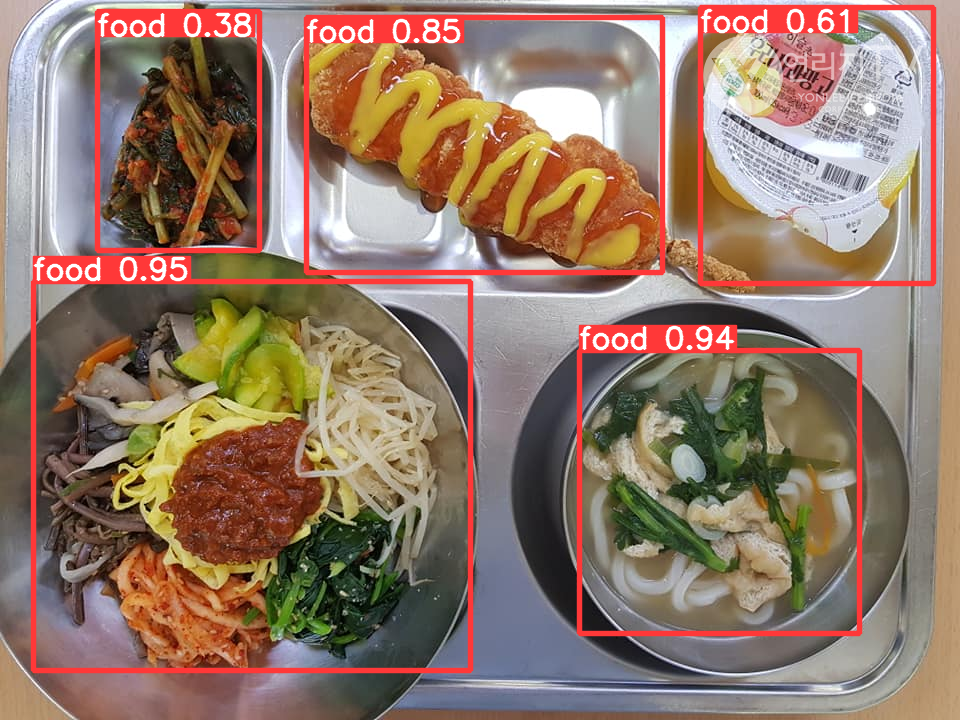

In [ ]:
image_url = 'http://www.yonleejee.com/news/photo/202006/1086_1595_213.jpg'
run_yolo(yolo, image_url)